In [5]:
!curl -o data/fra-eng.zip http://www.manythings.org/anki/fra-eng.zip
!unzip data/fra-eng.zip -d data/

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
 10 5986k   10  627k    0     0   608k      0  0:00:09  0:00:01  0:00:08  608k
 95 5986k   95 5735k    0     0  2822k      0  0:00:02  0:00:02 --:--:-- 2822k
100 5986k  100 5986k    0     0  2901k      0  0:00:02  0:00:02 --:--:-- 2901k


Archive:  data/fra-eng.zip
  inflating: data/_about.txt         
  inflating: data/fra.txt            


### Reading Data and Tokenization

In [2]:
import pandas as pd

data = pd.read_csv("fra.txt",sep='\t',header= None,encoding="utf-8")
ang = list(data[0])
fra = list(data[1])

from spacy.lang.en import English
from spacy.lang.fr import French

nlp = English()
tokenizer = nlp.Defaults.create_tokenizer(nlp)
nlp_f = French()
tokenizer_f = nlp_f.Defaults.create_tokenizer(nlp_f)

ang = [['<S>'] + [token.string.strip() for token in tokenizer(text.lower())] + ['</S>'] for text in ang][:10000]

fra = [['<S>'] + [token.string.strip() for token in tokenizer_f(text.lower())] + ['</S>'] for text in fra][:10000]

print(ang[1000])
print(fra[1000])

['<S>', 'stay', 'thin', '.', '</S>']
['<S>', 'reste', 'mince', '!', '</S>']


### Training Word2Vec

In [3]:
from gensim.models import Word2Vec
import numpy as np

EMBEDDING_SIZE = 120
w2v = Word2Vec(ang, size=EMBEDDING_SIZE, window=10, min_count=1, negative=10, workers=10)
word_map = {}
word_map["<PAD>"] = 0
word_vectors = [np.zeros((EMBEDDING_SIZE,))]
for i, w in enumerate([w for w in w2v.wv.vocab]):
    word_map[w] = i+1
    word_vectors.append(w2v.wv[w])
word_vectors = np.vstack(word_vectors)

w2v = Word2Vec(fra, size=EMBEDDING_SIZE, window=10, min_count=1, negative=10, workers=10)
word_map_fr = {}
word_map_fr["<PAD>"] = 0
word_vectors_fr = [np.zeros((EMBEDDING_SIZE,))]
for i, w in enumerate([w for w in w2v.wv.vocab]):
    word_map_fr[w] = i+1
    word_vectors_fr.append(w2v.wv[w])
word_vectors_fr = np.vstack(word_vectors_fr)
i2w = dict(zip([*word_map_fr.values()],[*word_map_fr]))

### Padding, word2id and shifting

In [4]:
def pad(a,shift = False):
    shape = len(a)
    max_s = max([len(x) for x in a])
    token = np.zeros((shape,max_s+1),dtype = np.int)
    mask  =  np.zeros((shape,max_s+1),dtype = np.int)
    for i,o in enumerate(a):
        token[i,:len(o)] = o
        mask[i,:len(o)] = 1
    if shift:
        return token[:,:-1],token[:,1:],mask[:,1:],max_s
    else:
        return token[:,:-1],mask[:,:-1],max_s
        

In [5]:
ang_tok,ang_mask,ang_pl = pad([[word_map[w] for w in text] for text in ang])
fra_tok,fra_tok_t,fra_mask,fr_pl = pad([[word_map_fr[w] for w in text] for text in fra],shift = True)

### Seq2Seq model

In [6]:
from tensorflow.keras import layers,Model
from tensorflow.keras.initializers import Constant
import tensorflow as tf

class S2S(tf.keras.Model):
    def __init__(self,Win,Wout,i2w):
      
        super(S2S, self).__init__() 
        
        self.nv_in = Win.shape[0]
        self.r = Win.shape[1]
        self.nv_out = Wout.shape[0]
        
        self.i2w = i2w
        
        self.Win = layers.Embedding(self.nv_in,self.r)
        self.Win.build((None, ))
        self.Win.set_weights([Win])
        self.Win.trainable = True

        self.Wout = layers.Embedding(self.nv_out,self.r)
        self.Wout.build((None, ))
        self.Wout.set_weights([Wout])
        self.Wout.trainable = True
        
        self.encoder = layers.GRU(self.r,dropout=0.2)
        
        self.decoder = layers.GRU(self.r, return_sequences=True, return_state=True,dropout=0.2)
        
        self.mapper = layers.Dense(self.nv_out,activation = "softmax")

    @tf.function
    def call(self,x,x_mask,x_out):
        x = self.Win(x)
        x_mask = tf.cast(x_mask,dtype=bool)
    
        x = self.encoder(x,mask=x_mask)   
        
        x_out = self.Wout(x_out)
        out,_ = self.decoder(x_out, initial_state=x)
        
        probs = self.mapper(out)

        return probs

    def generate(self,start_emb,stop_emb,x,x_mask):
        aout = []
        
        x = tf.expand_dims(x,axis=0)
        x_mask = tf.expand_dims(x_mask,axis=0)

        x_mask = tf.cast(x_mask,dtype=bool)
        
        x = self.Win(x)

        x = self.encoder(x,mask=x_mask) 
        
        x_out = tf.expand_dims(tf.expand_dims(self.Wout(start_emb),axis = 0),axis = 0)         
        _,out = self.decoder(x_out, initial_state=x) 
        probs = tf.squeeze(self.mapper(out))
        
        x_out = tf.math.argmax(probs)
        val,argval = tf.nn.top_k(probs, k=2, sorted=True, name=None)
        x_out = argval.numpy()[0]
        aout.append(self.i2w[x_out])
        
        for i in range(10):
            x_out = tf.expand_dims(tf.expand_dims(self.Wout(tf.constant(x_out)),axis = 0),axis = 0)     
            _,out = self.decoder(x_out, initial_state=out)  
            
            probs = tf.squeeze(self.mapper(out))
            val,argval = tf.nn.top_k(probs, k=2, sorted=True, name=None)
            x_out = argval.numpy()[0]
            aout.append(self.i2w[x_out])
            
            if x_out == stop_emb:
                break
            
        return aout


### Function for optim

In [7]:
@tf.function
def compute_loss(model,loss_f,x,x_mask,x_out,y_out,y_out_mask):
    
    
    probs = model(x,x_mask,x_out)
    
    y_true= tf.boolean_mask(y_out,y_out_mask)
    y_pred = tf.boolean_mask(probs,y_out_mask) 
    
    return loss_f(y_true,y_pred),y_true,y_pred


@tf.function
def compute_apply_gradients(model,loss_f,x,x_mask,x_out,y_out,y_out_mask, optimizer):

    with tf.GradientTape() as tape:
        
        loss,label,prediction= compute_loss(model, loss_f,x,x_mask,x_out,y_out,y_out_mask)
        
    gradients = tape.gradient(loss, model.trainable_variables)
    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss,label,prediction




### Split

In [8]:
batch_size = 3

X = np.hstack([ang_tok,ang_mask,fra_tok])
print(X.shape)
Y = np.hstack([fra_tok_t,fra_mask])
print(Y.shape)
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.80, random_state=101)


train_data = tf.data.Dataset.from_tensor_slices((X_train,Y_train)).batch(batch_size)

test_data = tf.data.Dataset.from_tensor_slices((X_test,Y_test)).batch(batch_size)


(10000, 33)
(10000, 30)


### Model declaration and training

In [9]:
model = S2S(word_vectors,word_vectors_fr,i2w)

In [10]:
from tqdm.notebook import tqdm
import os

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.CategoricalAccuracy(name='test_accuracy')

loss_f = tf.keras.losses.CategoricalCrossentropy()
    
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
loss_f = tf.keras.losses.CategoricalCrossentropy()
epochs = 30

checkpoint_dir = 'training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 model=model)

tr_loss = []
te_loss = []
tr_acc = []
te_acc = []
    
for epoch in range(1, epochs + 1):
    print(epoch,flush=True,)

    for x,y in tqdm(train_data):
        
        x,x_mask,x_out = tf.split(x,[ang_pl,ang_pl,fr_pl],axis=1)
        y_out,y_out_mask = tf.split(y,2,axis=1)
        
        y_out_onehot = tf.one_hot(y_out,depth = word_vectors_fr.shape[0])
        
        loss,label,prediction = compute_apply_gradients(model,loss_f,x,x_mask,x_out,y_out_onehot,y_out_mask,optimizer)

        train_loss(loss)
        train_accuracy(label, prediction)
        
    for x,y in tqdm(test_data):

        x,x_mask,x_out = tf.split(x,[ang_pl,ang_pl,fr_pl],axis=1)
        y_out,y_out_mask = tf.split(y,2,axis=1)

        y_out_onehot = tf.one_hot(y_out,depth = word_vectors_fr.shape[0])

        loss,label,prediction = compute_loss(model,loss_f,x,x_mask,x_out,y_out_onehot,y_out_mask)
        test_loss(loss)
        test_accuracy(label, prediction)
                
    print(" ".join(ang[1000]))
    print(" ".join(model.generate(word_map_fr["<S>"],word_map_fr["</S>"],ang_tok[1000,:],ang_mask[1000,:])))
    
    print(" ".join(ang[5000]))
    print(" ".join(model.generate(word_map_fr["<S>"],word_map_fr["</S>"],ang_tok[5000,:],ang_mask[5000,:])))
    
    print(
    f'Loss: {train_loss.result()}, '
    f'Accuracy: {train_accuracy.result() * 100}, '
    f'Test Loss: {test_loss.result()}, '
    f'Test Accuracy: {test_accuracy.result() * 100}')
    
    tr_loss.append(train_loss.result())
    te_loss.append(test_loss.result())
    tr_acc.append(train_accuracy.result())
    te_acc.append(test_accuracy.result())
    if epoch % 2 == 0:
        checkpoint.save(file_prefix=checkpoint_prefix)



1



<S> stay thin . </S>
ne suis pas ! </S>
<S> who wants it ? </S>
tu es  ? </S>
Loss: 3.7566001415252686, Accuracy: 42.119258880615234, Test Loss: 3.404664993286133, Test Accuracy: 48.970333099365234
2



<S> stay thin . </S>
ne me pas ! </S>
<S> who wants it ? </S>
qui est -ce ? </S>
Loss: 3.463655471801758, Accuracy: 46.95536422729492, Test Loss: 3.284498453140259, Test Accuracy: 51.64921188354492
3



<S> stay thin . </S>
ne me vous en aller . </S>
<S> who wants it ? </S>
qui a -il ? </S>
Loss: 3.2814064025878906, Accuracy: 49.62005615234375, Test Loss: 3.200606346130371, Test Accuracy: 53.2926139831543
4



<S> stay thin . </S>
il vous en aller . </S>
<S> who wants it ? </S>
qui a j' ai ? </S>
Loss: 3.1793503761291504, Accuracy: 51.44331359863281, Test Loss: 3.216062307357788, Test Accuracy: 54.34336853027344
5



<S> stay thin . </S>
-vous de l' ai ! </S>
<S> who wants it ? </S>
qui est -il ? </S>
Loss: 3.1737375259399414, Accuracy: 52.76131057739258, Test Loss: 3.2917897701263428, Test Accuracy: 55.1064567565918
6



<S> stay thin . </S>
ça . </S>
<S> who wants it ? </S>
qui est -il ? </S>
Loss: 3.196906805038452, Accuracy: 53.788536071777344, Test Loss: 3.3583779335021973, Test Accuracy: 55.66608428955078
7



<S> stay thin . </S>
pas . </S>
<S> who wants it ? </S>
qui est -il ? </S>
Loss: 3.2184431552886963, Accuracy: 54.659263610839844, Test Loss: 3.410325765609741, Test Accuracy: 56.119422912597656
8



<S> stay thin . </S>
nous soyez ! </S>
<S> who wants it ? </S>
qui est -il ? </S>
Loss: 3.2363057136535645, Accuracy: 55.42291259765625, Test Loss: 3.4499311447143555, Test Accuracy: 56.542320251464844
9



<S> stay thin . </S>
reste de ! </S>
<S> who wants it ? </S>
qui est pas  ? </S>
Loss: 3.249887466430664, Accuracy: 56.10646057128906, Test Loss: 3.4794795513153076, Test Accuracy: 56.903236389160156
10



<S> stay thin . </S>
reste  ! </S>
<S> who wants it ? </S>
qui est pas  ? </S>
Loss: 3.2596137523651123, Accuracy: 56.709312438964844, Test Loss: 3.501044988632202, Test Accuracy: 57.20942687988281
11



<S> stay thin . </S>
reste . </S>
<S> who wants it ? </S>
qui est -il  ? </S>
Loss: 3.2664265632629395, Accuracy: 57.25703811645508, Test Loss: 3.5183908939361572, Test Accuracy: 57.47897720336914
12


KeyboardInterrupt: 

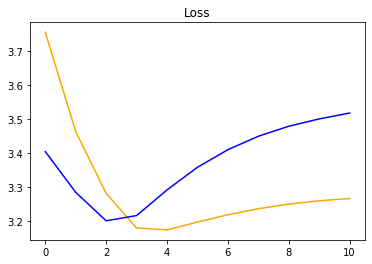

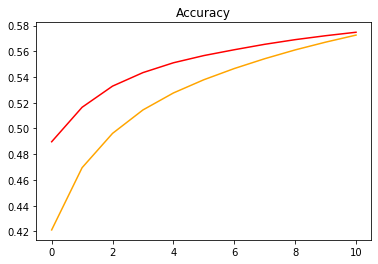

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(tr_loss, c="orange")
plt.plot(te_loss, c="blue")
plt.title("Loss")
plt.show()

plt.clf()
plt.plot(tr_acc, c="orange")
plt.plot(te_acc, c="red")
plt.title("Accuracy")
plt.show()